# The Impact of Ambient Temperature on Server Efficiency


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 

------

Plan:

- Load in all of the SERT results avoiding any invalid ones
- Merge data as needed 
- Generate graphs showing power consumption against load and temperature
- Find a trade-off between operating temperature and number of servers. 


In [76]:
import numpy as np
import pandas as pd
import re
import os.path
from os import makedirs
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from parse_results import process_results_xml
import yaml
#import influxdb_client

In [77]:
if os.path.isfile('settings.yaml'):
    with open('settings.yaml', 'r') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)
else:
    params = {}
    
sert_results_dir = params.get('results_dir', 'sert_results')
bios_setting_file = params.get('test_settings', 'test_settings.csv')
cpu_metrics_dir = params.get('cpu_metrics_dir', 'cpu_data')

working_dir = params.get('temp_dir', 'temp_dir')
all_data_file = params.get('data_file', 'all_data.csv')
overwrite_data = params.get('overwrite_data', False)

whitelist = params.get('whitelist', '')

# Generate and load the data (Run Once)

In [78]:
sert_data = pd.DataFrame()

if not os.path.isdir(working_dir):
    os.makedirs(working_dir, exist_ok=True)


if not os.path.isfile(f'{working_dir}//{all_data_file}') or overwrite_data:

    metrics_data = pd.DataFrame()
    test_details = pd.DataFrame()
    scores = pd.DataFrame()
    invalid_results = []   # List of skipped results because they're invalid

    for f in glob.glob(f'{sert_results_dir}//**//results.xml', recursive=True):
        try:
            # Name of test directory -- sert-xxxx
            test_name = os.path.basename(os.path.dirname(f))

            if os.path.isfile(f'{sert_results_dir}//{test_name}//invalid.png') and not test_name in whitelist:
                invalid_results.append(test_name)
                continue
            
            # Load the SERT result
            metrics, score, env = process_results_xml(f)

            file_df = pd.DataFrame.from_records(metrics)
            # Remove calibration runs but record the calibration score against each loadlevel to calculate actual loadlevel
            calibrations = file_df.loc[file_df['loadlevel']=='calibration', ['worklet', 'score']]
            calibrations = calibrations.rename(columns={'score': 'calibration-score'})

            file_df = pd.merge(file_df.drop(index=calibrations.index), calibrations, how='left', on='worklet')
            file_df['actual-load'] = file_df['score'] / file_df['calibration-score']
            file_df['test-name'] = test_name

            score_df = pd.DataFrame.from_records(score)
            score_df['test-name'] = test_name

            metrics_data = metrics_data.append(file_df, ignore_index=True)
            test_details = test_details.append(pd.DataFrame.from_records(env, index=[test_name]))
            scores = scores.append(score_df, ignore_index=True)

        except Exception as e:
            print(f, ': FAILED TO LOAD -- ', e, type(e))
    
    if len(invalid_results) > 0:    
        print(f'Invalid results skipped: {invalid_results}')

    # Load external details for test
    if bios_setting_file != '' and os.path.isfile(bios_setting_file):
        settings = pd.read_csv(bios_setting_file, index_col=0)
    else:
        settings = pd.DataFrame()
    #settings.columns = ['location', 'bios']
    test_details = pd.merge(test_details, settings, left_index=True, right_index=True)
    
    

    # Join metrics and test details to results.
    sert_data = pd.merge(metrics_data, scores, how='left', on=['test-name', 'worklet', 'loadlevel', 'workload', 'score', 'watts-avg'])
    sert_data = pd.merge(sert_data, test_details, left_on='test-name', right_index=True)
    sert_data.loc[sert_data['workload'] == 'Idle', 'actual-load'] = 0
    
    #Pressure lookup here for tunnel tests
    if 'influxdb' in params:
        from influxdb import InfluxDBClient
        client = InfluxDBClient(host=params['influxdb']['host'], 
                                port=params['influxdb']['port'], 
                                username=params['influxdb']['user'], 
                                password=params['influxdb']['password'],
                                database=params['influxdb']['tunnel-database'])

        def pressure_func(r):
            if r.location == 'Tunnel':
                query = f'select (mean("value")-21.65)*62/19 from sensors where "channel"=\'Pressure\' and time>=\'{r.start.isoformat()}\' and time<=\'{r.end.isoformat()}\''
                result = client.query(query)
                for pt in result.get_points('sensors'):
                    return pt['mean']

                return np.nan # Tunnel run but no data
            else:
                return 0

        sert_data['pressure'] = sert_data.apply(pressure_func, axis=1)

    # Store generated data
    metrics_data.to_csv(f'{working_dir}//sert_metrics.csv', index=False)
    test_details.to_csv(f'{working_dir}//test_details.csv')
    scores.to_csv(f'{working_dir}//scores.csv', index=False)
    sert_data.to_csv(f'{working_dir}//{all_data_file}', index=False)
    
else:
    print(f'Loading SERT data from disk')
    sert_data = pd.read_csv(f'{working_dir}//{all_data_file}', parse_dates=['start', 'end'])
    scores = pd.read_csv(f'{working_dir}//scores.csv')
    test_details = pd.read_csv(f'{working_dir}//test_details.csv', index_col=0)        

# Scenario column for easier display and filtering
sert_data['scenario'] = list(' - '.join(s) for s in zip(sert_data['model'], sert_data['cpu']))

# Drop any tests that were run without hyperthreading
sert_data.drop(sert_data[sert_data.logical_cores == sert_data.physical_cores].index, inplace=True)

Invalid results skipped: ['sert-0410', 'sert-0412', 'sert-0413', 'sert-0414', 'sert-0415', 'sert-0416', 'sert-0417', 'sert-0418', 'sert-0419', 'sert-0420', 'sert-0424', 'sert-0425']


In [79]:
sert_data['cpu'].unique()

array(['Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz'], dtype=object)

In [80]:
sert_data.head()    

,loadlevel,worklet,score,workload,watts-min,watts-max,watts-avg,start,end,temp-min,...,model,numa_nodes,physical_cores,psu,ref,vendor,location,bios,pressure,scenario
0,100%,Compress,63710.064993,CPU,433.46,436.68,434.779677,2021-10-05 07:39:39.659000+01:00,2021-10-05 07:40:40.189000+01:00,20.6250,...,PowerEdge R640,4,20,750,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,24.713321,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...
1,75%,Compress,47811.785938,CPU,416.10,422.28,419.398387,2021-10-05 07:40:52.488000+01:00,2021-10-05 07:41:53.029000+01:00,20.6875,...,PowerEdge R640,4,20,750,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,24.836626,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...
2,50%,Compress,31878.203852,CPU,313.75,362.90,319.439032,2021-10-05 07:42:05.250000+01:00,2021-10-05 07:43:05.545000+01:00,20.6250,...,PowerEdge R640,4,20,750,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,25.103754,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...
3,25%,Compress,15927.951299,CPU,215.83,223.23,220.501935,2021-10-05 07:43:17.850000+01:00,2021-10-05 07:44:18.077000+01:00,20.6875,...,PowerEdge R640,4,20,750,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,25.594138,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...
4,100%,CryptoAES,485330.257317,CPU,442.93,444.57,443.755806,2021-10-05 07:55:13.800000+01:00,2021-10-05 07:56:14.415000+01:00,20.6875,...,PowerEdge R640,4,20,750,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,24.585540,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...


In [81]:
sert_data.describe()

,score,watts-min,watts-max,watts-avg,temp-min,temp-max,temp-avg,calibration-score,actual-load,norm-score,ref-score,efficiency-score,dimms,logical_cores,numa_nodes,physical_cores,pressure
count,1.640000e+02,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,1.440000e+02,148.000000,160.000000,160.000000,160.000000,164.0,164.0,164.0,164.0,164.000000
mean,6.139156e+05,299.957439,310.987012,304.287035,20.657012,20.702744,20.679320,7.862286e+05,0.607118,6.826741,90131.503500,19.889625,8.0,80.0,4.0,20.0,25.060857
std,1.246860e+06,113.993053,115.157937,114.462076,0.086605,0.088421,0.084188,1.199127e+06,0.296622,7.152685,136430.136961,14.898598,0.0,0.0,0.0,0.0,0.279530
min,0.000000e+00,84.840000,87.400000,85.903115,20.375000,20.500000,20.433036,3.076997e+02,0.000000,0.772229,11.520000,5.730455,8.0,80.0,4.0,20.0,24.213561
25%,1.487949e+04,218.520000,224.987500,221.156129,20.625000,20.625000,20.625000,6.243563e+04,0.374497,2.939483,5437.512500,13.258379,8.0,80.0,4.0,20.0,24.924225
50%,1.006907e+05,315.490000,335.360000,322.110573,20.687500,20.687500,20.687500,1.828941e+05,0.503168,5.328156,15946.510000,16.391827,8.0,80.0,4.0,20.0,25.059424
75%,3.788260e+05,413.012500,417.132500,415.152097,20.687500,20.750000,20.742101,4.419852e+05,0.875041,8.271465,81279.882500,21.253771,8.0,80.0,4.0,20.0,25.198408
max,6.622201e+06,444.290000,452.050000,446.472645,20.812500,20.875000,20.862500,3.026706e+06,1.021176,44.715837,354112.340000,101.424648,8.0,80.0,4.0,20.0,26.166062


In [82]:
#test_details
total_score = scores[scores['workload'] == 'All'].dropna(axis=1)
total_score = total_score.merge(test_details, left_on='test-name', right_index=True, how='left').dropna()
total_score['scenario'] = list(' - '.join(x) for x in zip(total_score['model'], total_score['cpu']))
total_score['temperature'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-avg'].mean(), axis=1)
total_score['temperature-range'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-max'].max() - sert_data[sert_data['test-name'] == row['test-name']]['temp-min'].min(), axis=1)
total_score = total_score.merge(sert_data[sert_data['workload'] == 'Idle'][['watts-avg','test-name']], left_on='test-name', right_on='test-name').rename(columns={'watts-avg':'idle-power'})
total_score['max-power'] = total_score.apply(lambda row: sert_data[(sert_data['test-name'] == row['test-name']) & (sert_data['loadlevel']=='100%')]['watts-avg'].mean(), axis=1)
total_score['pressure'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['pressure'].mean(), axis=1)
total_score

,workload,efficiency-score,test-name,cpu,dimm_size_mb,dimms,hostname,logical_cores,model,numa_nodes,...,ref,vendor,location,bios,scenario,temperature,temperature-range,idle-power,max-power,pressure
0,All,21.269568,sert-0411,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,20.750827,0.2500,86.290328,354.591873,25.018007
1,All,21.032842,sert-0421,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,20.663743,0.4375,86.218033,352.986507,25.028904
2,All,21.105384,sert-0422,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,20.615169,0.3125,85.903115,352.910175,25.141814
3,All,21.075316,sert-0423,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,8192,8,WIN-47K2HVKE78P,80,PowerEdge R640,4,...,R640-E5Silver-750W-Eff_BIOS,Dell Inc.,Tunnel,Efficiency,PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CP...,20.687543,0.3125,86.277869,353.291867,25.054701


# What scenarios have been tested?
Using a 3 bin strategy for temperature testing and high and low for pressure.

In [86]:
tested = total_score.groupby(['scenario', 'bios', pd.cut(total_score.pressure, [total_score.pressure.min(), 15, total_score.pressure.max()]), pd.cut(total_score.temperature,[20, 23.33,26.66, 30])]).size().unstack().unstack()
tested.style.applymap(lambda x: 'background-color:pink' if x < 3 else None)

ValueError: bins must increase monotonically.

Mean
 scenario
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz      24.061000
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v2 @ 3.00GHz     21.759720
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz     21.570111
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz      20.719185
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz    24.427565
Name: temp-avg, dtype: float64

Variance
 scenario
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0 @ 2.90GHz      3.556322
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v2 @ 3.00GHz     0.835946
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v3 @ 2.60GHz     1.265041
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz      0.004489
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz    6.961698
Name: temp-avg, dtype: float64


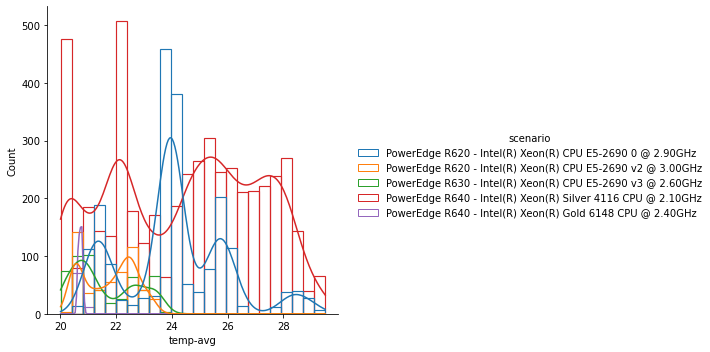

In [ ]:
print('Mean\n', sert_data.groupby('scenario')['temp-avg'].mean())
print('\nVariance\n', sert_data.groupby('scenario')['temp-avg'].var())
sns.displot(data=sert_data, x="temp-avg", hue="scenario", kde=True, fill=False)

C:\Users\D.Burdett\Anaconda3\envs\data-analysis\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


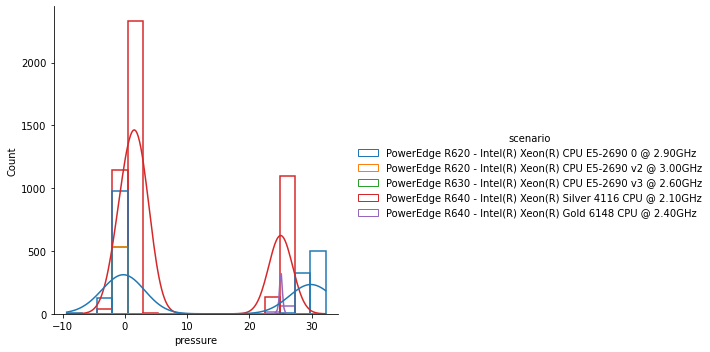

In [ ]:
sns.displot(data=sert_data, x="pressure", hue="scenario", kde=True, fill=False)

In [ ]:
print(list(sert_data[sert_data.logical_cores == sert_data.physical_cores]['test-name'].unique()), list(sert_data[sert_data.logical_cores == sert_data.physical_cores]['bios'].unique()))

[] []


# Effects on overall SERT score

# Efficiency and power consumption measured by SERT

For the CPU workelts in particular, we can plot the benchmark load against the efficiency score achevied for each scenario. 

Text(0.5, 1.1, 'CPU Worklet Power Consumption')

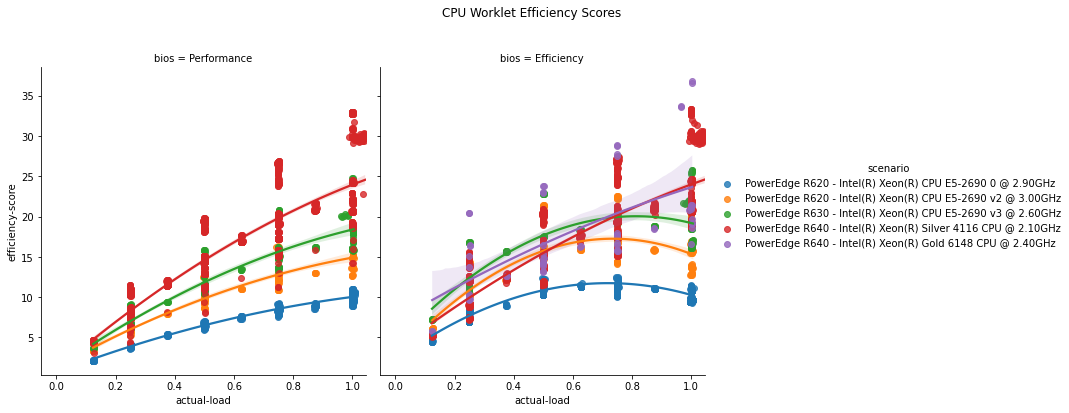

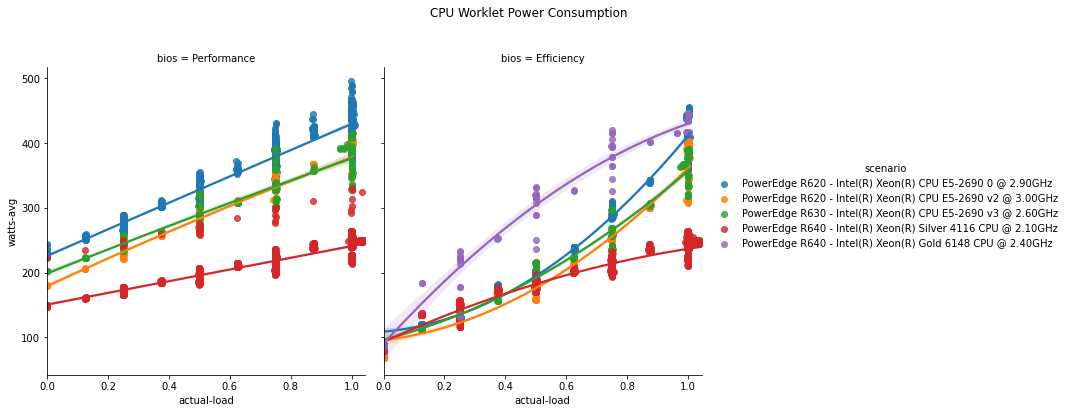

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]

sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 30], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Efficiency Scores', y=1.1)
sns.lmplot(x='actual-load', y='watts-avg', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 30], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Power Consumption', y=1.1)

Text(0.5, 1.1, 'CPU Worklet Power Consumption')

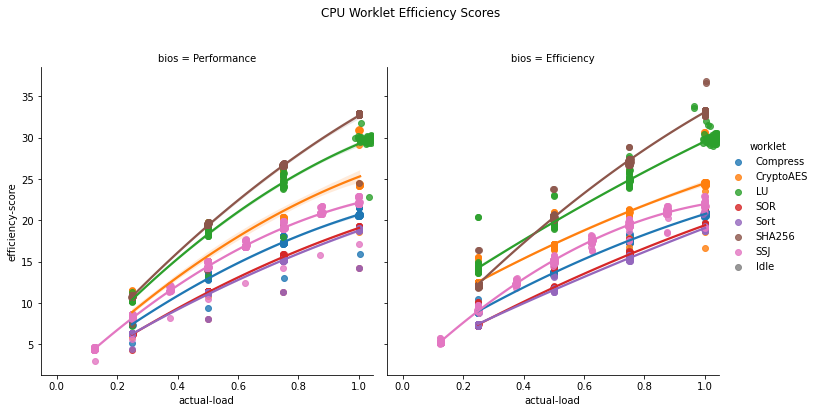

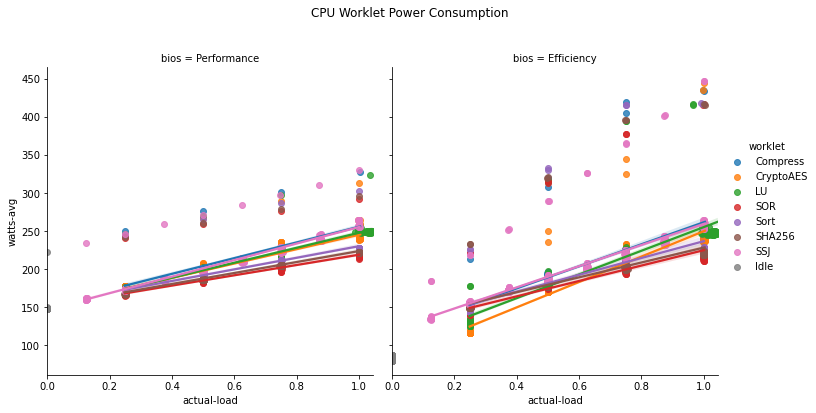

In [ ]:
sns.lmplot(x='actual-load', y='efficiency-score', hue='worklet', col='bios', 
           data=cpu[cpu['model'] == 'PowerEdge R640'], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Efficiency Scores', y=1.1)
sns.lmplot(x='actual-load', y='watts-avg', hue='worklet', col='bios', 
           data=cpu[cpu['model'] == 'PowerEdge R640'], order=1, truncate=True, scatter=True).fig.suptitle('CPU Worklet Power Consumption', y=1.1)

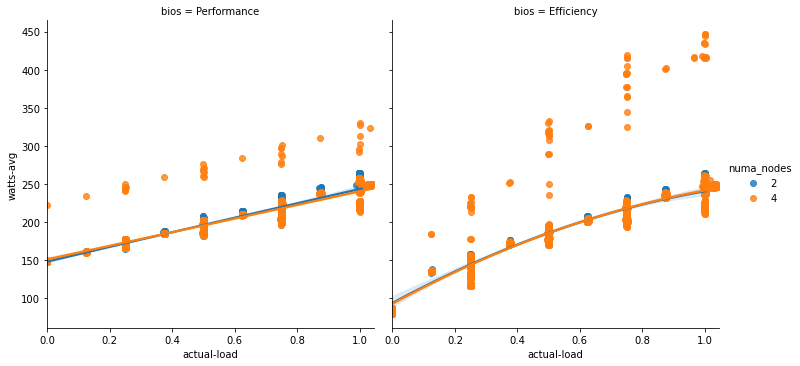

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]

sns.lmplot(x='actual-load', y='watts-avg', hue='numa_nodes', col='bios', 
           data=cpu[cpu['model'] == 'PowerEdge R640'], order=2, truncate=True, scatter=True)

In [ ]:
sert0208 = sert_data[(sert_data['test-name'] == 'sert-0208')].drop(columns=['score','watts-min','watts-max','watts-avg','watts-avg','start','end','temp-min','vendor','bios','location','pressure','loadlevel','temp-max','temp-avg','actual-load','test-name','efficiency-score','norm-score'])
#sert0208.columns

r640 = sert_data[(sert_data['model'] == 'PowerEdge R640')].drop(columns=['score','watts-min','watts-max','watts-avg','watts-avg','start','end','temp-min','vendor','bios','location','pressure','loadlevel','temp-max','temp-avg','actual-load','test-name','efficiency-score','norm-score'])
#r640.columns

pd.concat([sert0208,r640]).drop_duplicates(keep=False)



,worklet,workload,calibration-score,ref-score,cpu,dimm_size_mb,dimms,hostname,logical_cores,model,numa_nodes,physical_cores,psu,ref,scenario


A cleaner plot without the individual data plotted for each sert run. 

Text(0.5, 1.0, 'CPU Worklet Efficiency Scores ( Test Temperature < 22.5C)')

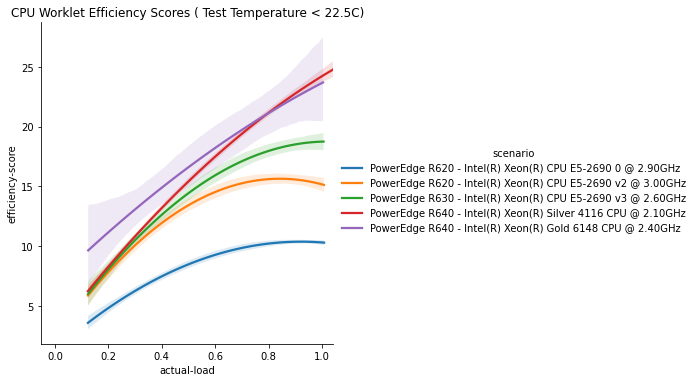

In [ ]:
sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', data=cpu[cpu['temp-avg'] < 22.5], order=2, truncate=True, scatter=False)
ax = plt.gca()
ax.set_title('CPU Worklet Efficiency Scores ( Test Temperature < 22.5C)')

The environmental conditions for the tests are as follows:

In [ ]:
df = total_score
df2 = df.loc[(df['scenario'] == 'PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 CPU @ 2.10GHz') & (df['bios'] == 'Performance') & (df['temperature'] > 22) & (df['temperature'] < 24) & (df['efficiency-score'] < 20)]
df2['test-name']



134    sert-0208
Name: test-name, dtype: object

# The Effect of Temperature
The overall efficiency score across various temperatures

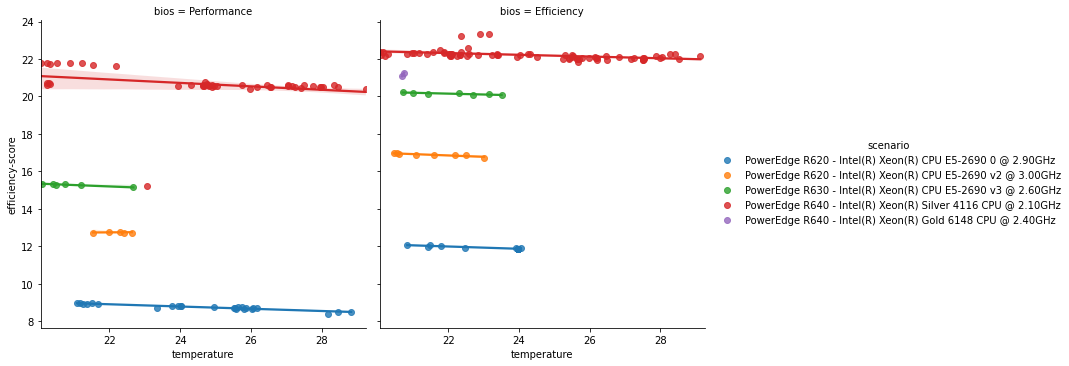

In [ ]:
sns.lmplot(data=total_score, x='temperature', y='efficiency-score', hue='scenario', col='bios')

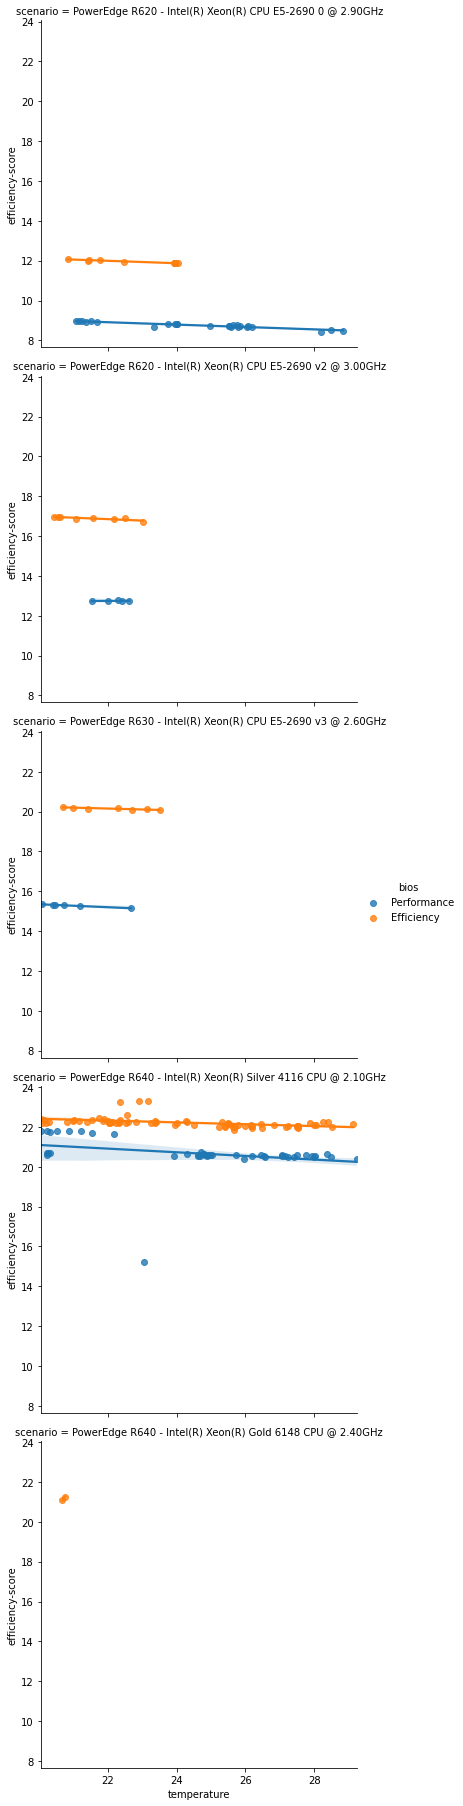

In [ ]:
sns.lmplot(data=total_score, x='temperature', y='efficiency-score', hue='bios', row='scenario')

In [ ]:
total_score[total_score['temperature'] < 22].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()


efficiency-score  \
scenario                                           bios                            
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency          12.037269   
                                                   Performance          8.942559   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency          16.928111   
                                                   Performance         12.740748   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency          20.190678   
                                                   Performance         15.305247   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency          21.172442   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency          22.310756   
                                                   Performance         21.376266   

                                                                temperature  \
scenario                                           bios                       
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency     21.380781   
                                                   Performance    21.347824   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency     20.859912   
                                                   Performance    21.768351   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency     21.044298   
                                                   Performance    20.584085   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency     20.719185   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency     20.948800   
                                                   Performance    20.533201   

                                                                idle-power  \
scenario                                           bios                      
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency    87.911557   
                                                   Performance  224.827104   
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency    68.950525   
                                                   Performance  180.414099   
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency    87.944973   
                                                   Performance  202.128262   
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency    86.284098   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency    83.984218   
                                                   Performance  147.807914   

                                                                 max-power  
scenario                                           bios                     
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency   340.473106  
                                                   Performance  375.170355  
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency   300.372455  
                                                   Performance  333.451099  
PowerEdge R630 - Intel(R) Xeon(R) CPU E5-2690 v... Efficiency   300.358096  
                                                   Performance  335.828491  
PowerEdge R640 - Intel(R) Xeon(R) Gold 6148 CPU... Efficiency   353.941870  
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency   203.384250  
                                                   Performance  220.491421

In [ ]:
total_score[total_score['temperature'] > 28].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()

efficiency-score  \
scenario                                           bios                            
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance          8.471665   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency          22.150179   
                                                   Performance         20.513576   

                                                                temperature  \
scenario                                           bios                       
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance    28.499776   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency     28.472061   
                                                   Performance    28.529895   

                                                                idle-power  \
scenario                                           bios                      
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance  237.742732   
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency    82.458015   
                                                   Performance  149.081781   

                                                                 max-power  
scenario                                           bios                     
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Performance  400.241379  
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Efficiency   205.728675  
                                                   Performance  218.560985

In [ ]:
cpu[(cpu['loadlevel'] == '100%')].groupby([ 'worklet','scenario', 'bios'])['norm-score'].mean().unstack().pct_change(axis=1).abs().mean()

bios
Efficiency          NaN
Performance    0.004285
dtype: float64

In [ ]:
cpu[(cpu.model == 'PowerEdge R640') & (cpu.worklet == 'CryptoAES') & (cpu.loadlevel == '100%')].groupby('bios')['norm-score'].mean()

bios
Efficiency     5.958048
Performance    6.224721
Name: norm-score, dtype: float64

In [ ]:
cpu[['worklet', 'loadlevel', 'scenario', 'bios', 'score']].groupby(['scenario', 'bios', 'worklet', 'loadlevel']).mean()

score
scenario                                           bios        worklet   loadlevel              
PowerEdge R620 - Intel(R) Xeon(R) CPU E5-2690 0... Efficiency  Compress  100%       3.052345e+04
                                                                         25%        7.638482e+03
                                                                         50%        1.527715e+04
                                                                         75%        2.288662e+04
                                                               CryptoAES 100%       2.423685e+05
...                                                                                          ...
PowerEdge R640 - Intel(R) Xeon(R) Silver 4116 C... Performance SSJ       87.5%      1.776312e+06
                                                               Sort      100%       8.958286e+04
                                                                         25%        2.239221e+04
                                                                         50%        4.478206e+04
                                                                         75%        6.717043e+04

[297 rows x 1 columns]

# CPU Power

The CPU is usually considered the driver of most power consumption in the server (excluding any expansion cards). During the SERT tests we have also recorded low-level performance registers of the CPU like per-core frequency and also power consumption. 

Todo: 
- Determine relationship between chassis and CPU power consumption
    - Assume power = P_Idle + P_Chassis + P_CPU
    - IS P_Chassis a function of CPU power?
    
    
Read the CPU power data in and summarise for the tests

In [ ]:
cpu_metrics = pd.DataFrame()

if not os.path.exists(f'{working_dir}//cpu_metrics.csv') or overwrite_data :
    
    for f in glob.glob(f'{cpu_metrics_dir}//**.csv', recursive=True):
        try:
            samples = pd.read_csv(f, skiprows=8, header=0, index_col=0, parse_dates=['Time'], encoding='cp1252')
            if not pd.api.types.is_datetime64_any_dtype(samples.index.dtype):
                # Final row contains "Session end:"
                samples.drop('Session end:', inplace=True)
                samples.index = pd.to_datetime(samples.index)

            cpu_metrics = cpu_metrics.append(samples)
        except:
            print(f'FAILED LOADING FILE: {f}')

    cpu_metrics.sort_index(inplace=True)
    cpu_metrics['total cpu power'] = cpu_metrics['CPU 0 Power'] + cpu_metrics['CPU 1 Power']
    
    cpu_metrics.to_csv(f'{working_dir}//cpu_metrics.csv')
    
else:
    cpu_metrics = pd.read_csv(f'{working_dir}//cpu_metrics.csv', index_col='Time', parse_dates=['Time'])
    

C:\Users\D.Burdett\Anaconda3\envs\data-analysis\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
cpu_metrics['avg-temp'] = cpu_metrics.filter(regex='Temp').mean(axis=1, skipna=True)
cpu_metrics['avg-load'] = cpu_metrics.filter(regex='load').mean(axis=1, skipna=True)
cpu_metrics['avg-freq'] = cpu_metrics.filter(regex='speed').mean(axis=1, skipna=True)


#pd.to_datetime(cpu_metrics['Time']
sert_data['cpu-power'] = sert_data.apply(lambda row: cpu_metrics['total cpu power'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['chassis-power'] = sert_data['watts-avg'] - sert_data['cpu-power']

sert_data['cpu-temp'] = sert_data.apply(lambda row: cpu_metrics['avg-temp'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-load'] = sert_data.apply(lambda row: cpu_metrics['avg-load'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-freq'] = sert_data.apply(lambda row: cpu_metrics['avg-freq'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)



<ipython-input-27-8af0337eb9f5>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cpu_metrics['avg-temp'] = cpu_metrics.filter(regex='Temp').mean(axis=1, skipna=True)


Looking again at the server efficiency scores, but now using the CPU utilsiation dat from the OS rather than the load data calculated by SERT. SERT load is a proportion of the total score/transactions acheived during the calibration runs. OS CPU utilisaiton is the proportion of time the CPU is busy performing operations. 

C:\Users\D.Burdett\Anaconda3\envs\data-analysis\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Text(0.5, 1.1, 'Efficiency Scores ( Test Temperature < 22.5C)')

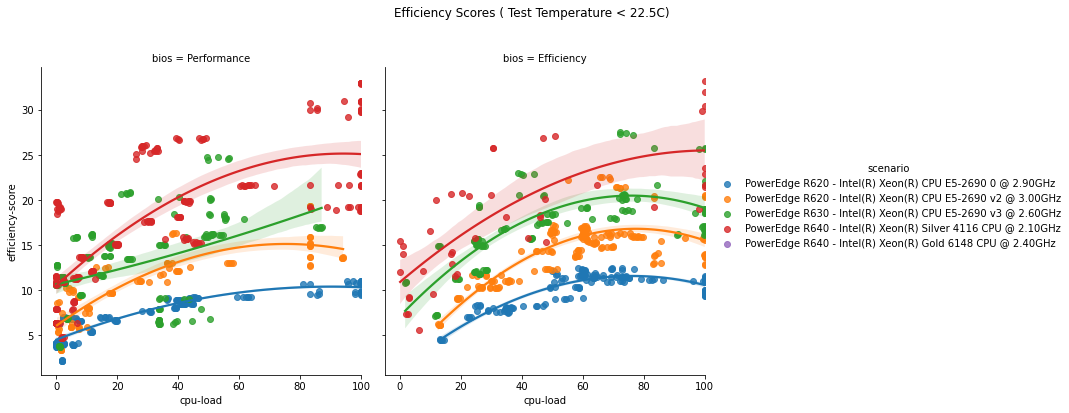

In [ ]:
cpu_worklets = sert_data[(sert_data['workload'] == 'Idle') | (sert_data['workload'] == 'CPU')]
cpu_worklets['scenario'] = list(' - '.join(x) for x in zip(cpu_worklets['model'], cpu_worklets['cpu']))
sns.lmplot(x='cpu-load', y='efficiency-score', hue='scenario', col='bios', data=cpu_worklets[cpu_worklets['temp-avg'] < 22.5], order=2, truncate=True, scatter=True).fig.suptitle('Efficiency Scores ( Test Temperature < 22.5C)', y=1.1)


This is a significantly different relationship than that shown for the SERT load. 

Breaking down the performance per server and per worklet.

Text(0.5, 1.1, 'Efficiency Scores')

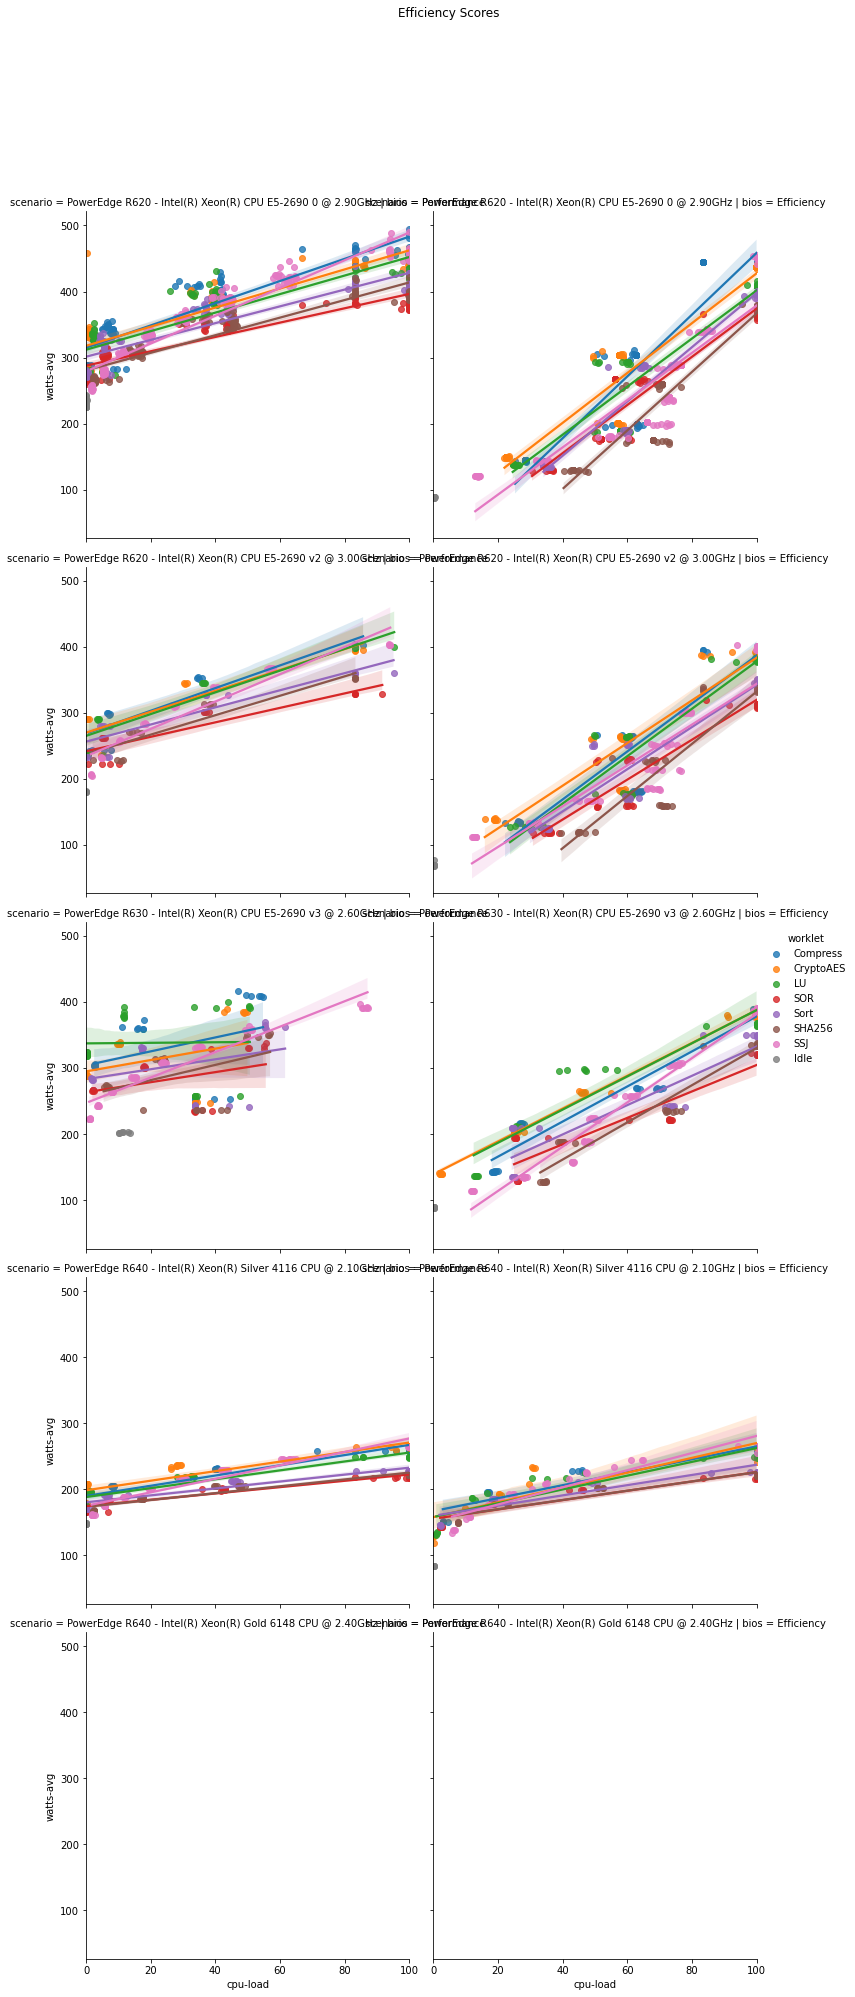

In [ ]:

    sns.lmplot(x='cpu-load', y='watts-avg', hue='worklet', col='bios', row='scenario', data=cpu_worklets, order=1, truncate=True, scatter=True).fig.suptitle(f'Efficiency Scores', y=1.1)


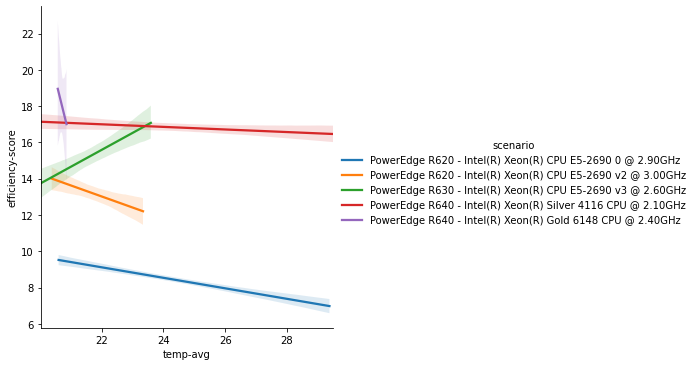

In [ ]:
sns.lmplot(x='temp-avg', y='efficiency-score', hue='scenario', data=cpu_worklets, order=1, scatter=False)

# CPU power consumption

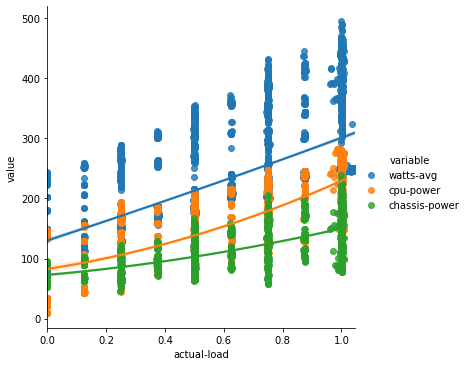

In [ ]:
plotdf = cpu_worklets.melt('actual-load', ['watts-avg', 'cpu-power', 'chassis-power'])

sns.lmplot(x='actual-load', y='value', hue='variable', data=plotdf, order=2)

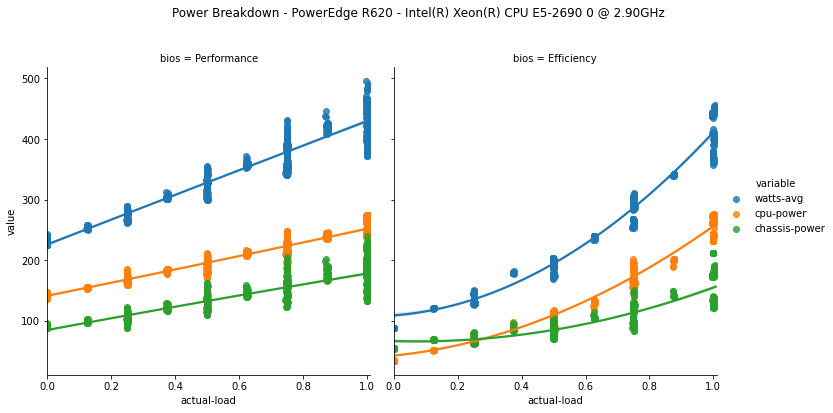

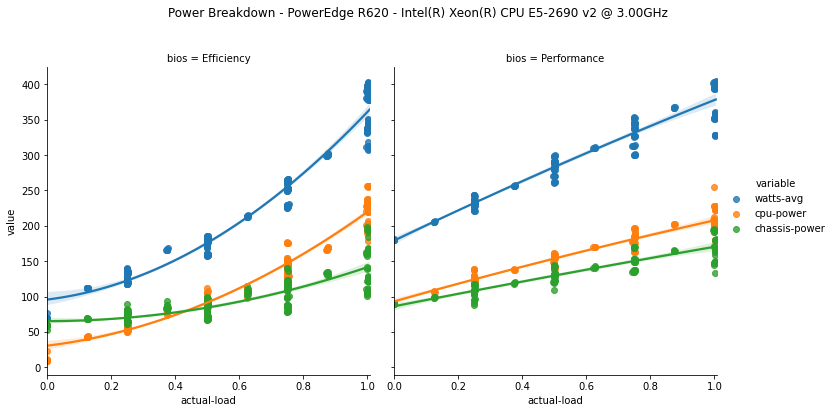

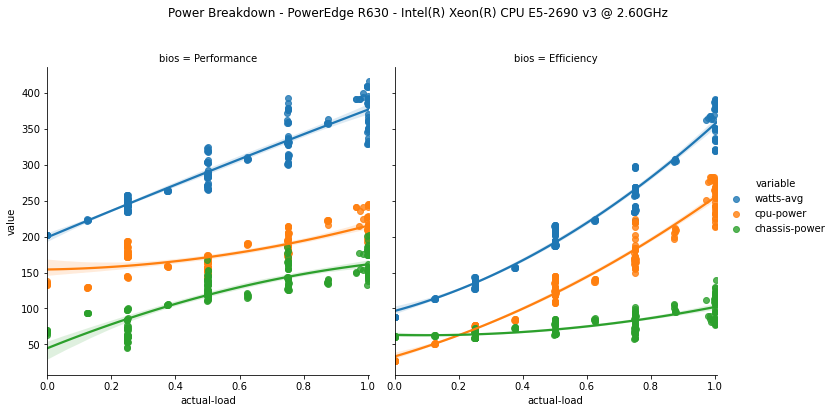

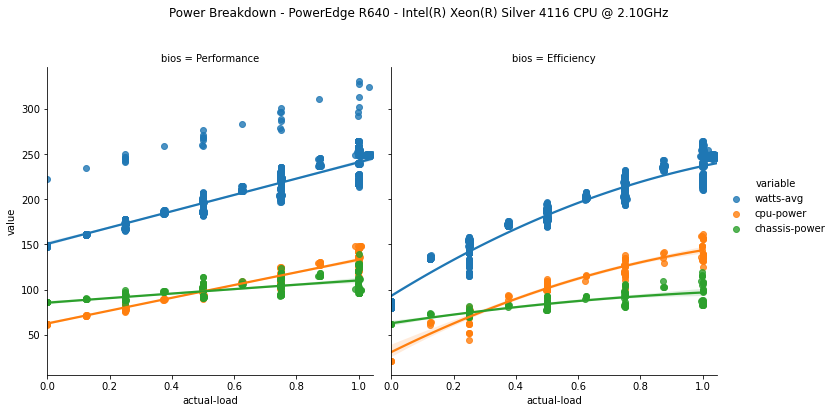

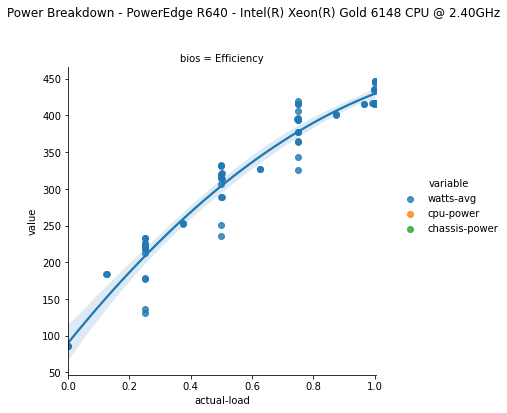

In [ ]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['actual-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

In [ ]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['cpu-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

KeyError: "['actual-load'] not in index"

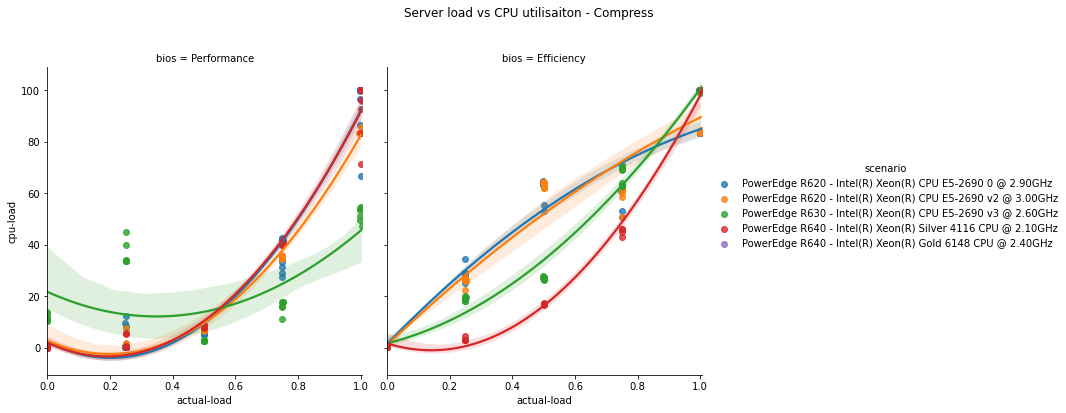

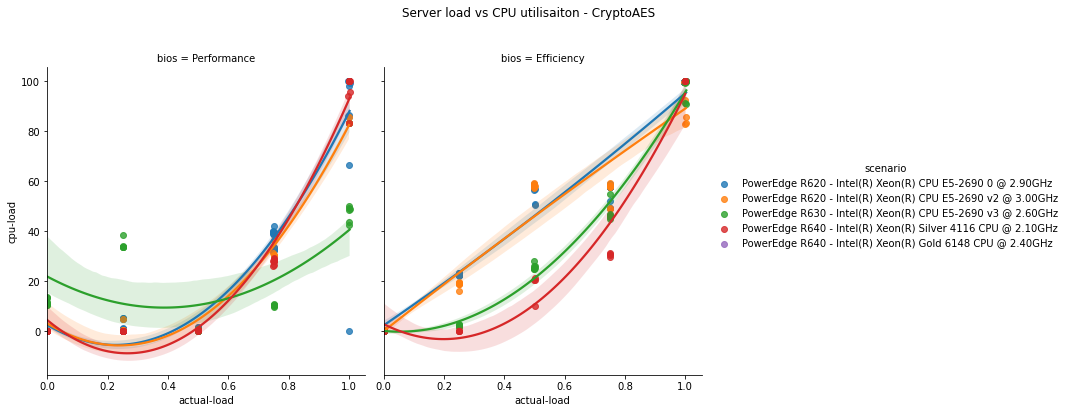

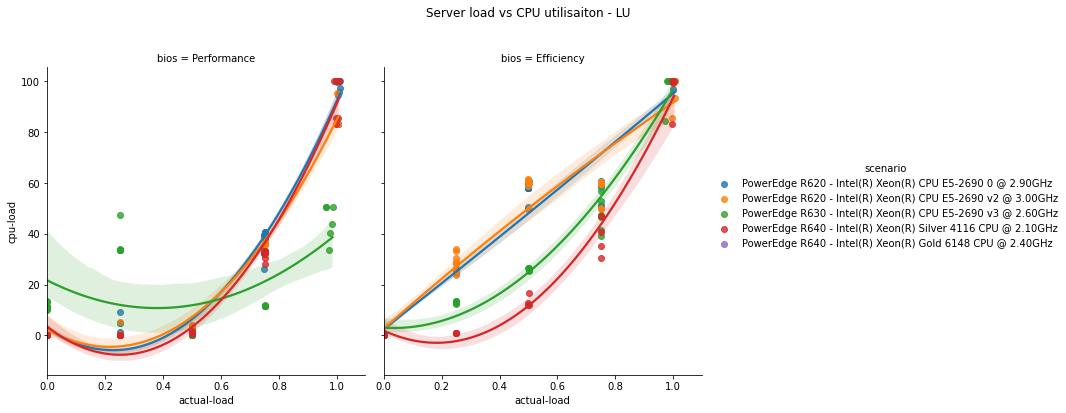

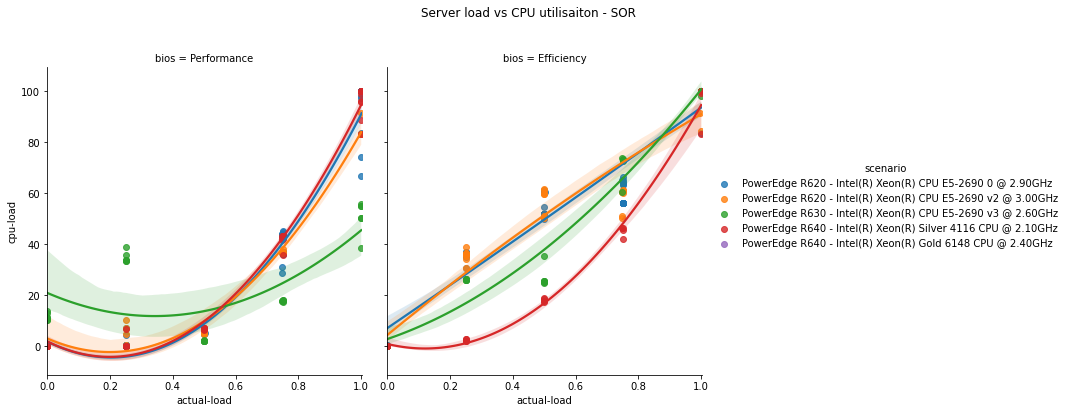

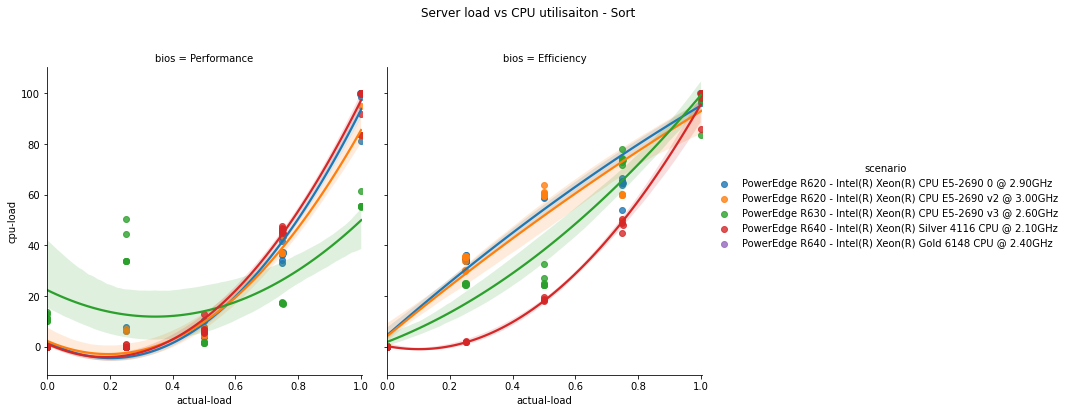

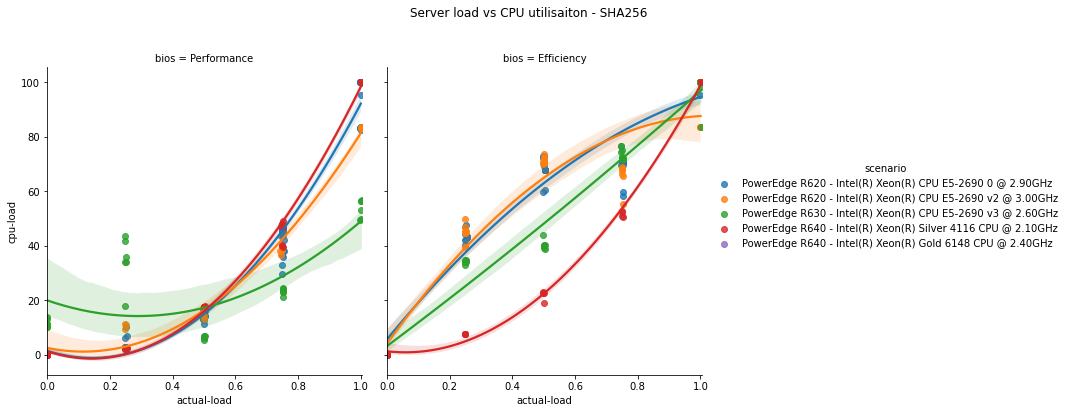

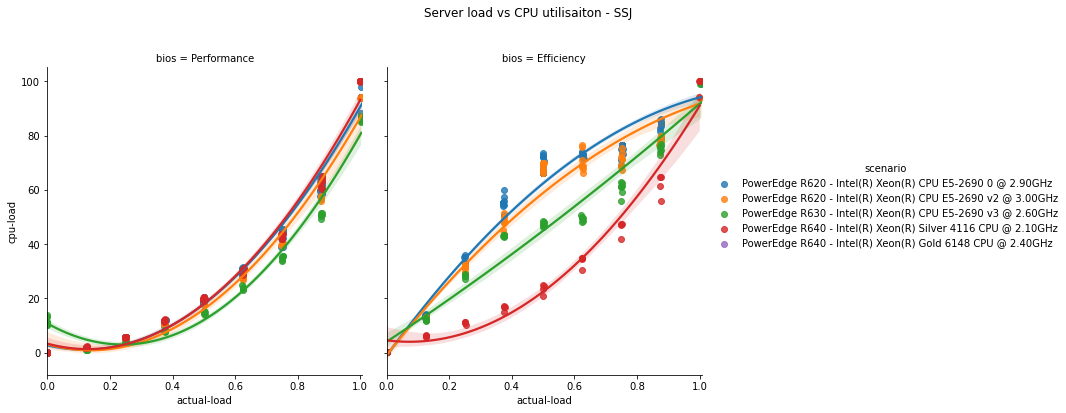

In [ ]:
for worklet in sert_data[sert_data['workload'] == 'CPU']['worklet'].unique():
    sns.lmplot(data=sert_data[(sert_data['worklet'] == worklet) | (sert_data['workload'] == 'Idle')], x='actual-load', y='cpu-load', hue='scenario', col='bios', order=2).fig.suptitle(f'Server load vs CPU utilisaiton - {worklet}', y=1.1)

<AxesSubplot:xlabel='temp-avg', ylabel='watts-avg'>

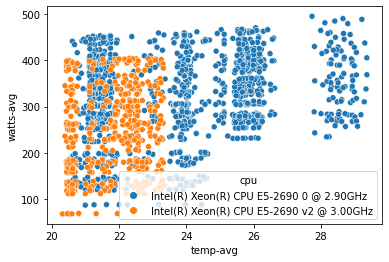

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = cpu[cpu['model'] == 'PowerEdge R620']
#cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]


#sns.lmplot(x='cpu-power', y='chassis-power', hue='worklet', data=cpu, order=2)
sns.scatterplot(x='temp-avg', y='watts-avg', hue='cpu', data=cpu)

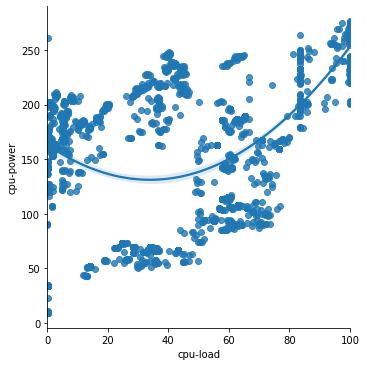

In [ ]:
sns.lmplot(x='cpu-load', y='cpu-power', data=cpu, order=2)

Text(0.5, 1.0, 'R620 E5-2690, Efficiency (DPAC) Mode')

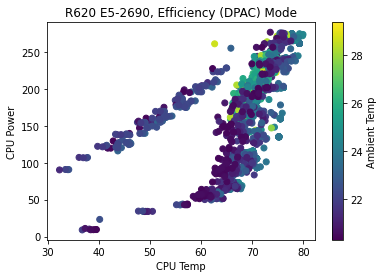

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['temp-avg'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Ambient Temp', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

Text(0.5, 1.0, 'R620 E5-2690, Efficiency (DPAC) Mode')

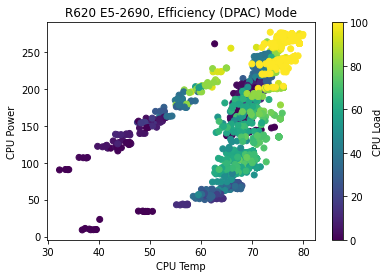

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

Text(0.5, 1.0, 'R620 E5-2690, Efficiency (DPAC) Mode')

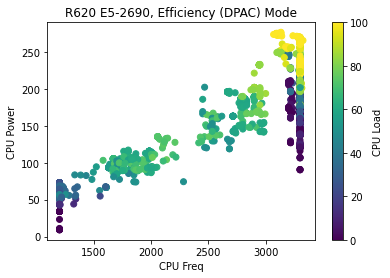

In [ ]:
ax = plt.scatter(x=cpu['cpu-freq'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Freq')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')